<a href="https://colab.research.google.com/github/kevlord997/ML_Algorithmic_Trading_Projects/blob/lesson-5/ML_Trading_L5_Class_Balance_and_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# 1. INSTALLATION: We need imbalanced-learn for SMOTE
!pip install yfinance pandas ta scikit-learn imbalanced-learn --quiet

# 2. IMPORTS: Grouping related tools
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from sklearn.ensemble import RandomForestClassifier # Our new model!
from imblearn.over_sampling import SMOTE # Our imbalance fix!
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# 3. DATA RETRIEVAL (Review): Downloading the time series data
ticker = "SPY"
spy_data = yf.download(ticker, start="2010-01-01", end="2024-01-01")
spy_data.columns = spy_data.columns.get_level_values(0)
spy_data.rename(columns={'Close': 'Adj Close'}, inplace=True)

/tmp/ipython-input-4039270284.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download(ticker, start="2010-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [16]:
spy_data.head(10)

Price,Adj Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,85.279221,85.324368,83.909697,84.556835,118944600
2010-01-05,85.504929,85.542555,84.917991,85.226513,111579900
2010-01-06,85.565163,85.775858,85.354468,85.422189,116074400
2010-01-07,85.926361,86.031709,85.166349,85.407144,131091100
2010-01-08,86.212296,86.249922,85.527536,85.700605,126402800
2010-01-11,86.332703,86.633692,85.963980,86.596072,106375700
2010-01-12,85.527542,85.941406,85.196447,85.760811,163333500
2010-01-13,86.249893,86.490688,85.309286,85.745724,161822000
2010-01-14,86.483170,86.641191,86.099400,86.152074,115718800


In [17]:
# 4. FEATURE ENGINEERING: Creating the X variables

# Simple Moving Averages (Laggards - Measure Trend)
spy_data['SMA_20'] = spy_data['Adj Close'].rolling(window=20).mean()
spy_data['SMA_100'] = spy_data['Adj Close'].rolling(window=100).mean()

# Relative Strength Index (Oscillator - Measure Momentum/Condition)
# RSI is one of the most critical trading indicators.
rsi_indicator = RSIIndicator(close=spy_data['Adj Close'], window=14)
spy_data['RSI'] = rsi_indicator.rsi()

# Momentum (Directly measures price change over N periods)
spy_data['MOM'] = spy_data['Adj Close'].diff(periods=10)

# 5. TARGET VARIABLE (Deep Dive): The Y variable, our future prediction
N = 5 # Predict 5 days in the future
spy_data['Future_Price'] = spy_data['Adj Close'].shift(-N)

# np.where is a powerful function: If condition is true, return 1, else return 0.
spy_data['Target'] = np.where(spy_data['Future_Price'] > spy_data['Adj Close'], 1, 0)

# Final cleanup
spy_data.dropna(inplace=True)

# Define X and Y
X = spy_data[['SMA_20', 'SMA_100', 'RSI', 'MOM']]
Y = spy_data['Target']

# Deep Dive Question 1: Why is it crucial to drop NaN values?
# (Answer: NaN values represent incomplete data points where one or more features/target cannot be calculated. ML algorithms cannot handle them.)

In [18]:
# 6. TIME SERIES SPLIT (Deep Dive): Maintaining chronological order
split_point = int(len(X) * 0.8)

# Why use slicing ([:split_point]) instead of train_test_split(..., shuffle=True)?
# (Answer: To prevent data leakage. Shuffling a time series allows the model to "see" the future when training, leading to artificially inflated, useless accuracy.)
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

# 7. FEATURE SCALING (Deep Dive): Standardizing the feature ranges
scaler = StandardScaler()
# Why fit_transform on train, but only transform on test?
# (Answer: The model must learn the standard deviation and mean *only* from the training data. Applying the transform to the test set ensures the test data is treated as 'new, unseen' data, preventing information leakage.)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# 8. IMBALANCE CORRECTION (Deep Dive): Synthesizing minority samples
smote = SMOTE(random_state=42)
# We apply SMOTE only to the *scaled training data*
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

print(f"\nOriginal Training Y shape: {Y_train.value_counts()}")
print(f"Resampled Training Y shape: {Y_train_resampled.value_counts()}")


Original Training Y shape: Target
1    1692
0    1042
Name: count, dtype: int64
Resampled Training Y shape: Target
1    1692
0    1692
Name: count, dtype: int64



--- Random Forest Model Evaluation (SMOTE) ---
Accuracy on Test Set: 0.5819

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       287
           1       0.58      1.00      0.74       397

    accuracy                           0.58       684
   macro avg       0.79      0.50      0.37       684
weighted avg       0.76      0.58      0.43       684



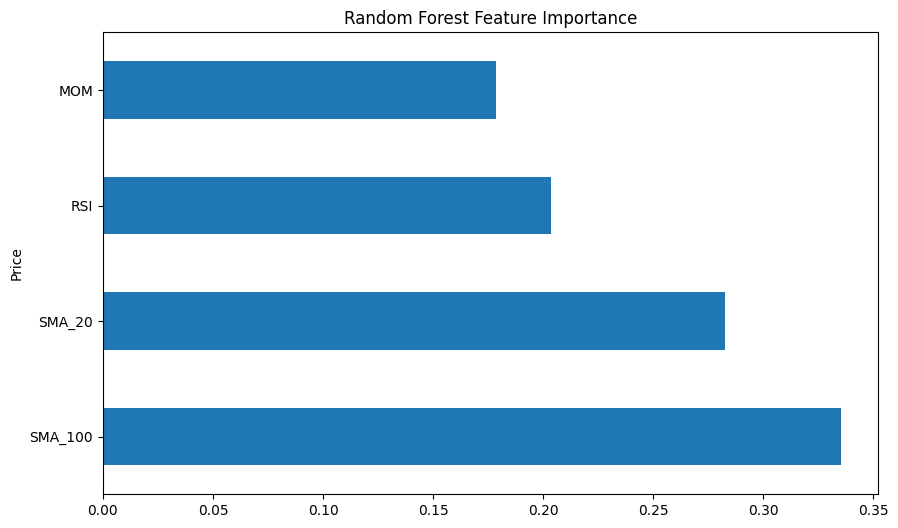

In [20]:
# 9. MODEL TRAINING: Using the superior Random Forest Classifier
# n_estimators=100 means we train 100 individual decision trees.
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_resampled, Y_train_resampled) # TRAIN on the balanced data!

# 10. PREDICTION & EVALUATION
rf_Y_pred = rf_model.predict(X_test_scaled) # PREDICT on the original, unseen test data

print(f"\n--- Random Forest Model Evaluation (SMOTE) ---")
print(f"Accuracy on Test Set: {accuracy_score(Y_test, rf_Y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, rf_Y_pred))

# Plot Feature Importance (Random Forest is great at this too)
import matplotlib.pyplot as plt
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh', title='Random Forest Feature Importance')
plt.show()

In [21]:
print(feature_importances)

Price
SMA_20     0.282645
SMA_100    0.335287
RSI        0.203465
MOM        0.178603
dtype: float64
